In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2023-04-14 15:45:13.168876+02:00


# 0. import libraries, general settings and define functions

In [2]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import os
import Bio
import scanpy as sc
import csv

from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from tqdm import tqdm
from Bio import SeqIO

In [79]:
#Function to obtain cell type specific mean expression of a list of genes
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [73]:
#Function to created a sorted genelist for dotplots
def sorted_dotplot(adata, gene_list, replace, save_name):
    gene_matrix = grouped_obs_mean(adata[:, gene_list], group_key='cell_type')
    gene_matrix = gene_matrix[celltypes_by_family]
    
    # Create a dictionary to store the lists for each column
    max_index = {}
    
    # Loop through each row
    for i, row in gene_matrix.iterrows():
        # Find the column with the maximum value in this row
        max_col = row.idxmax()
        # Add the row index to the list for that column in the dictionary
        if max_col in max_index:
            max_index[max_col].append(i)
        else:
            max_index[max_col] = [i]
        
    # Sort the dictionary keys by the index of the key in the predefined list
    sorted_keys = sorted(max_index.keys(), key=lambda x: celltypes_by_family.index(x) if x in celltypes_by_family else len(celltypes_by_family))

    # Create a new dictionary with the sorted keys
    sorted_max_index = {k: max_index[k] for k in sorted_keys}
    
    #create sorted list that can be used for the dotplot input
    sorted_genes = sum(sorted_max_index.values(), [])
    
    adata.var['manual'] = adata.var.index
    adata.var['manual'] = adata.var['manual'].replace(replace)
    
    sc.pl.dotplot(adata, use_raw=False,
            groupby='cell_type',
            var_names=adata.var.loc[sorted_genes]['manual'],
            swap_axes=True,
            categories_order=celltypes_by_family, gene_symbols = 'manual', save=f'{save_name}')
    plt.tight_layout()
    

Save all plots in the following folder:

In [69]:
sc.settings.figdir = '../paper/figures/suppl_figs/suppl-fig-secretion-dotplots/'

# 1. Standard preprocessing of Spongilla single cell data

The single cell data/cell type atlas of Spongilla lacustris stems from Musser, et al. 2021.

In [40]:
# adata = sc.read_loom("/g/arendt/data/spongilla_singlecell_dataset/UCSC_files/spongilla_seurat_object_corrected.loom", sparse=True)
# adata.write("../data/spongilla_basic.h5ad")
adata = sc.read('../data/spongilla_basic.h5ad')

In [41]:
numbers = ['2', '3', '6', '7', '12', '13', '14', '15', '16', '17', '19', '20', '23', '26', '29', '32', '34', '38', '42']
keep = ~adata.obs['cell_type'].isin(numbers)
adata = adata[keep].copy()

In [42]:
celltypes_by_family = [
    'Incurrent Pinacocytes1', 'Incurrent Pinacocytes2',
    'Apendopinacocytes1', 'Apendopinacocytes2', 'Lophocytes', 'Basopinacocytes', 'Sclerophorocytes', 'Metabolocytes1',
    'Metabolocytes2', 'Choanoblasts1', 'Choanoblasts2', 'Choanocytes', 'Apopylar Cells', 
    'Myopeptidocytes1', 'Myopeptidocytes2', 'Amoebocytes', 'Granulocytes', 'Neuroid', 'Mesocytes 1',
    'Mesocytes 2', 'Mesocytes 3', 'Archaeocytes', 'Sclerocytes'
]

In [43]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize first

adata.raw = adata #safe normalized, non log counts in raw

sc.pp.log1p(adata) #log scale the counts. This way both raw (normalized) and log scaled counts can be used for the dotplots.

# 2. Define gene lists for plotting

In this script I am producting the single cell RNA seq dotplots for the secretion experiments. We detected several proteins of a ER chaperone complex as well as almost all proteins of the TRIC chaperonin complex in the supernatant of sponges. 

Additionally, upon agitation, we see a secretion of many proteinases into the supernatant as well as a decrease of ROS catabolizing enzymes in the supernatant.

In this script, we will look at the cell type specific expression of these proteins.

In [52]:
proteinases = ['c100898-g3 (cathepsin) - emapper OG', 
               'c96393-g1 3-to-9 CPA1,CPB2,CPA2,CPA4... carboxypeptidase A1',
               'c103992-g1 TPP1 (Tripeptidyl peptidase I) - emapper OG',
               'c102960-g3 2-to-1 NPEPPS aminopeptidase puromycin sensitive',
               'c99308-g1 2-to-1 CNDP1 carnosine dipeptidase 1',
               'c103969-g1 1-to-1 PREP prolyl endopeptidase',
               'c104061-g1 1-to-1 PEPD peptidase D',
               'c103258-g1 1-to-1 NPEPL1 aminopeptidase like 1',
               'c104647-g2 1-to-1 LAP3 leucine aminopeptidase 3'
               ]



ROS_degrading = ['c104520-g1 1-to-2 ALDH1L2,ALDH1L1 aldehyde dehydrogenase 1 family member L2', 
                'c101807-g3 2-to-1 CAT catalase',
                 'c88295-g1 ALDH2 (Aldehyde dehydrogenase 1 family, member) - emapper OG',
                 'c90804-g1 PRDX6 (Peroxiredoxin 6) - emapper OG',
                 'c91813-g1 (Dyp-type peroxidase family) - emapper OG',
                 'c95358-g1 SOD2 (Destroys radicals which are normally produced within the cells and which are toxic to biological systems (By similarity)) - emapper OG',
                 'c101807-g2 2-to-1 CAT catalase',
                 'c104128-g1 MLT-7 (Peroxidasin homolog) - emapper OG',
                 'c93044-g1 SOD (Destroys radicals which are normally produced within the cells and which are toxic to biological systems) - emapper OG'
                 ]

for i in range(len(ROS_degrading)):
    ROS_degrading[i] = ROS_degrading[i][:110]

ER_chaperone_complex = ['c103368-g1 HSP90B1 (heat shock protein 90kDa beta (Grp94), member 1) - emapper OG',
                         'c110122-g1 P4HB (protein disulfide isomerase family A, member 2) - emapper OG',
                         'c104733-g1 1-to-1 HYOU1 hypoxia up-regulated 1',
                         'c88024-g1 PDIA3 (Protein disulfide isomerase family A, member) - emapper OG',
                         'c110643-g1 1-to-2 PPIB,PPIC peptidylprolyl isomerase B',
                         'c39783-g1 1-to-1 HSPA5 heat shock protein family A (Hsp70) member 5'
                         ]

Tric_chaperonin = ['c101223-g1 1-to-1 CCT7 chaperonin containing TCP1 subunit 7',
                   'c101169-g1 1-to-2 CCT6A,CCT6B chaperonin containing TCP1 subunit 6A',
                   'c92647-g1 1-to-1 CCT5 chaperonin containing TCP1 subunit 5',
                   'c102224-g1 CCT3 (Chaperonin containing Tcp1, subunit 3 (Gamma)) - emapper OG',
                   'c98583-g1 1-to-1 CCT8 chaperonin containing TCP1 subunit 8'
                   ]

In [61]:
replace = {'c100898-g3 (cathepsin) - emapper OG' : 'c100898-g3 CTSS/CTSK/CTSL1/CTSV - []', 
            'c96393-g1 3-to-9 CPA1,CPB2,CPA2,CPA4... carboxypeptidase A1' : 'c96393-g1 CPA1/2/3/4/5/6 - [CPA2]',
            'c103992-g1 TPP1 (Tripeptidyl peptidase I) - emapper OG' : 'c103992-g1 TPP1 - [TPP1]',
            'c102960-g3 2-to-1 NPEPPS aminopeptidase puromycin sensitive' : 'c102960-g3 NPEPPS - [NPEPPS]',
            'c99308-g1 2-to-1 CNDP1 carnosine dipeptidase 1' : 'c99308-g1 CNDP1 - [peptidase M20 M25 M40 family protein]',
            'c103969-g1 1-to-1 PREP prolyl endopeptidase' : 'c103969-g1 PREP - [PREP]',
            'c104061-g1 1-to-1 PEPD peptidase D' : 'c104061-g1 PEPD - [PEPD]',
            'c103258-g1 1-to-1 NPEPL1 aminopeptidase like 1' : 'c103258-g1 NPEPL1 - [NPEPL1]',
            'c104647-g2 1-to-1 LAP3 leucine aminopeptidase 3' : 'c104647-g2 LAP3 - [LAP3]',
           
            'c104520-g1 1-to-2 ALDH1L2,ALDH1L1 aldehyde dehydrogenase 1 family member L2' : 'c104520-g1 ALDH1L1/2 - [ALDH1L2]', 
            'c101807-g3 2-to-1 CAT catalase' : 'c101807-g3 CAT - [CAT]',
            'c88295-g1 ALDH2 (Aldehyde dehydrogenase 1 family, member) - emapper OG' : 'c88295-g1 ALDH1B1/ALDH2 - [ALDH2]',
            'c90804-g1 PRDX6 (Peroxiredoxin 6) - emapper OG' : 'c90804-g1 PRDX6 - [PRDX6]',
            'c91813-g1 (Dyp-type peroxidase family) - emapper OG' : 'c91813-g1 (Dyp-type peroxidase family) - [Dyp-type peroxidase family]',
            'c95358-g1 SOD2 (Destroys radicals which are normally produced within the cells and which are toxic to biologic' : 'c95358-g1 SOD2 - [SOD2]',
            'c101807-g2 2-to-1 CAT catalase' : 'c101807-g2 CAT - [CAT]',
            'c104128-g1 MLT-7 (Peroxidasin homolog) - emapper OG' : 'c104128-g1 PXDNL/PXDN/EPX/MPO/LPO/TPO - [PXDN]',
            'c93044-g1 SOD (Destroys radicals which are normally produced within the cells and which are toxic to biologica' : 'c93044-g1 SOD1 - [SOD1]',
           
            'c103368-g1 HSP90B1 (heat shock protein 90kDa beta (Grp94), member 1) - emapper OG' : 'c103368-g1 HSP90B1 - [HSP90B1]',
            'c110122-g1 P4HB (protein disulfide isomerase family A, member 2) - emapper OG' : 'c110122-g1 P4HB/PDILT/PDIA2 - [P4HB]',
            'c104733-g1 1-to-1 HYOU1 hypoxia up-regulated 1' : 'c104733-g1 HYOU1 - [HYOU1]',
            'c88024-g1 PDIA3 (Protein disulfide isomerase family A, member) - emapper OG' : 'c88024-g1 PDIA3 - [PDIA3]',
            'c110643-g1 1-to-2 PPIB,PPIC peptidylprolyl isomerase B' : 'c110643-g1 PPIB/C - [PPIB]',
            'c39783-g1 1-to-1 HSPA5 heat shock protein family A (Hsp70) member 5' : 'c39783-g1 HSPA5 - [HSPA5]',
           
            'c101223-g1 1-to-1 CCT7 chaperonin containing TCP1 subunit 7' : 'c101223-g1 CCT7 - [CCT7]',
            'c101169-g1 1-to-2 CCT6A,CCT6B chaperonin containing TCP1 subunit 6A' : 'c101169-g1 CCT6A/B - [CCT6A]',
            'c92647-g1 1-to-1 CCT5 chaperonin containing TCP1 subunit 5' : 'c92647-g1 CCT5 - [CCT5]',
            'c102224-g1 CCT3 (Chaperonin containing Tcp1, subunit 3 (Gamma)) - emapper OG' : 'c102224-g1 CCT3 - [CCT3]',
            'c98583-g1 1-to-1 CCT8 chaperonin containing TCP1 subunit 8' : 'c98583-g1 CCT8 - [CCT8]'
}

/g/arendt/Fabian/PhD/Computational/conda_environments/spongeprot/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


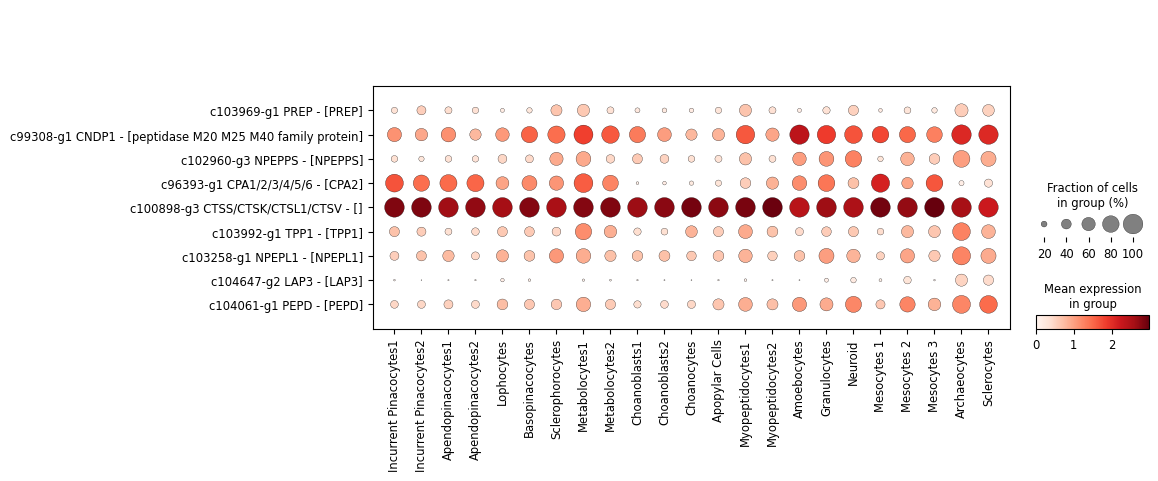

<Figure size 640x480 with 0 Axes>

In [75]:
sorted_dotplot(adata, proteinases, replace, 'proteinases.svg')

/g/arendt/Fabian/PhD/Computational/conda_environments/spongeprot/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


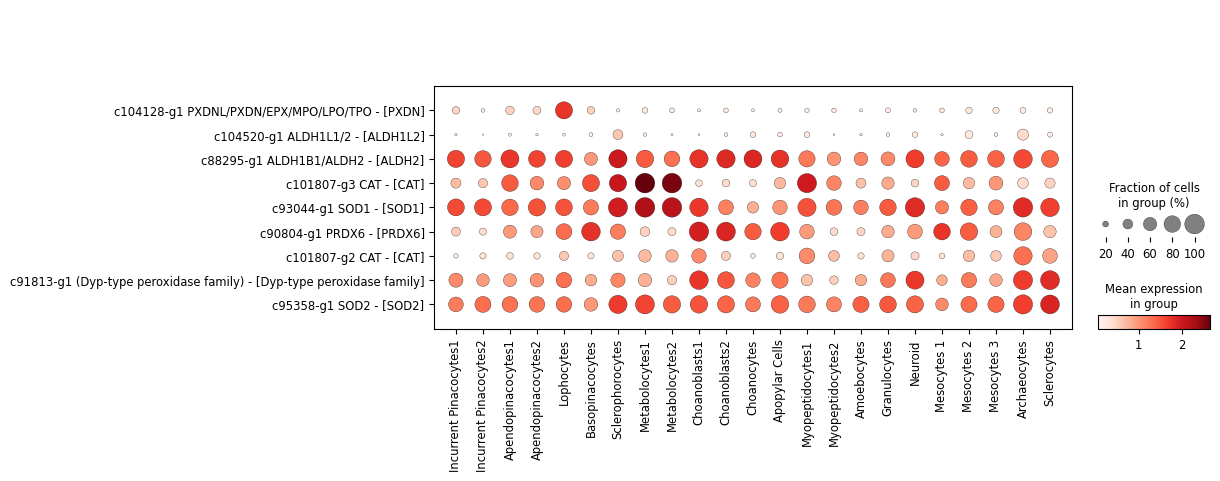

<Figure size 640x480 with 0 Axes>

In [76]:
sorted_dotplot(adata, ROS_degrading, replace, 'ROS_degrading.svg')

/g/arendt/Fabian/PhD/Computational/conda_environments/spongeprot/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


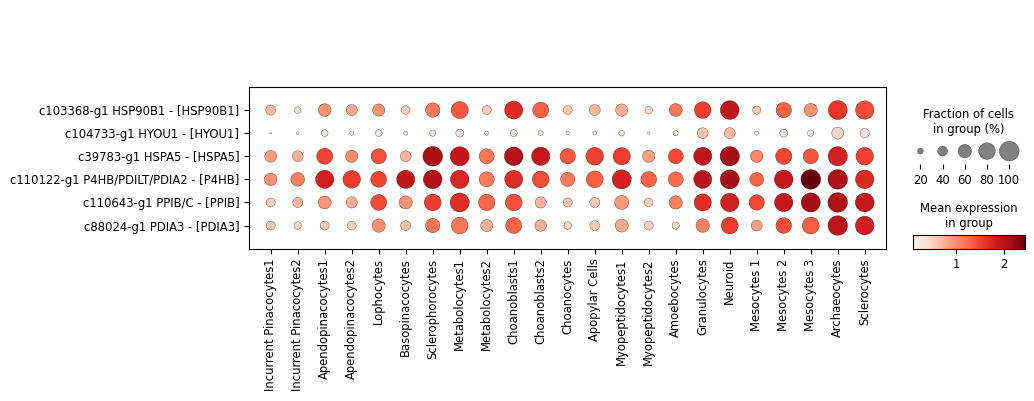

<Figure size 640x480 with 0 Axes>

In [77]:
sorted_dotplot(adata, ER_chaperone_complex, replace, 'ER_chaperone.svg')

/g/arendt/Fabian/PhD/Computational/conda_environments/spongeprot/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


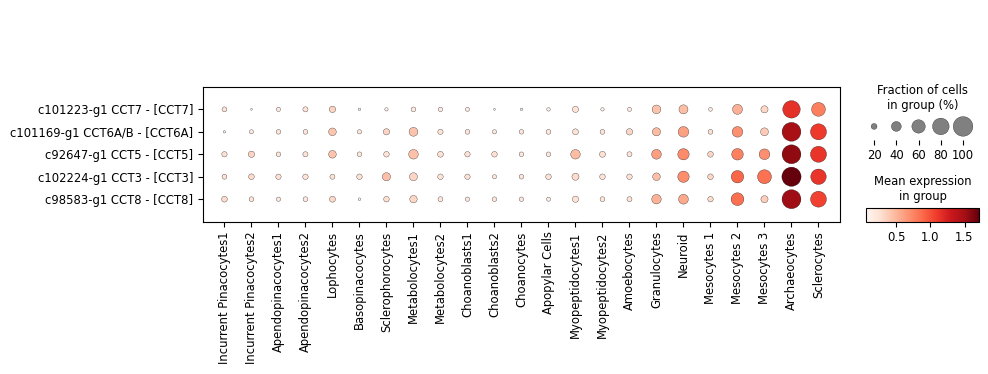

<Figure size 640x480 with 0 Axes>

In [78]:
sorted_dotplot(adata, Tric_chaperonin, replace, 'Tric_chaperonin.svg')